# Time Series data Exploration On NYC Trip Record Data

#### Data Information:-
I have downloaded data from link:- https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
 Jan2015 data

#### About data:-
The yellow and green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP).

## Lets start  Exploratory Data Analysis

In [1]:
# Import all used packages
import pandas as pd
import folium #open street map

import datetime
import time
import numpy as np
import matplotlib
matplotlib.use('nbagg') # for more intractive visualization like zoom out
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo #Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Load data
file = test_data_file = "../data-set/yellow_tripdata_2015-01.csv"
all_data = pd.read_csv(file)

In [3]:
#jan_data = all_data.loc[all_data.tpep_pickup_datetime.str.startswith("2019-1")]
print("Jan2015 data row and columns informantion")
print(all_data.shape)
print(all_data.columns)

Jan2019 data row and columns informantion
(12748986, 19)
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
#Print Sample data
all_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


###### So here we can see total 18 columns is there details of each column can be found pdf link .
https://data.cityofnewyork.us/api/views/biws-g3hs/files/eb3ccc47-317f-4b2a-8f49-5a684b0b1ecc?download=true&filename=data_dictionary_trip_records_yellow.pdf

For our Analysis I will use few columns and details of columns are:-
1. tpep_pickup_datetime -- The date and time when the meter was engaged.
2. tpep_dropoff_datetime -- The date and time when the meter was disengaged.
3. Passenger_count -- The number of passengers in the vehicle.
4. Trip_distance -- The elapsed trip distance in miles reported by the taximeter.
5. Pickup_longitude -- Longitude where the meter was engaged.
6. Pickup_latitude -- Latitude where the meter was engaged.
7. Dropoff_longitude -- Longitude where the meter was disengaged.
8. Dropoff_ latitude -- Latitude where the meter was disengaged.
9. Fare_amount -- The time-and-distance fare calculated by the meter.
10. Total_amount -- The total amount charged to passengers. Does not include cash tips.



In [5]:
jan_data = all_data[
                    ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                     'passenger_count', 'trip_distance', 'pickup_longitude',
                     'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 
                     'fare_amount','total_amount']
                   ]
del(all_data)

######  univariate analysis:-
lets start analysis of each feature and will see how features are changing in time

###### *# #####################################################################@

### 1. Pickup and Dropoff time

In [6]:
#Conver python date formate type into unix time format to deal better way as unix's time is presents in Seconds
jan_data["pickup_time_unix"] = jan_data.tpep_pickup_datetime.apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))
jan_data["dropoff_time_unix"] = jan_data.tpep_dropoff_datetime.apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))

In [7]:
#Make New Trip Duration feature using pickup and dropoff time
jan_data["trip_duration"] = (jan_data['dropoff_time_unix'].astype(int) - jan_data['pickup_time_unix'].astype(int))/float(60)

In [8]:
#Make New Trip Speed feature for analysis
jan_data["speed"] = 60*(jan_data["trip_distance"]/jan_data["trip_duration"])

In [9]:
#Sorting data frame as 
jan_data.sort_values(["pickup_time_unix","dropoff_time_unix"], inplace=True)

In [10]:
jan_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,total_amount,pickup_time_unix,dropoff_time_unix,trip_duration,speed
8166884,2015-01-01 00:00:00,2015-01-01 00:00:00,1,1.68,-73.991547,40.750069,0.000000,0.000000,10.0,10.8,1.420051e+09,1.420051e+09,0.000000,inf
8166885,2015-01-01 00:00:00,2015-01-01 00:00:00,3,1.56,-74.001320,40.729057,-74.010208,40.719662,7.5,8.8,1.420051e+09,1.420051e+09,0.000000,inf
8166863,2015-01-01 00:00:00,2015-01-01 00:11:26,5,4.00,-73.971436,40.760201,-73.921181,40.768269,13.5,14.5,1.420051e+09,1.420051e+09,11.433333,20.991254
8166886,2015-01-01 00:00:01,2015-01-01 00:03:49,1,0.80,-73.860847,40.757294,-73.868111,40.752285,5.0,6.3,1.420051e+09,1.420051e+09,3.800000,12.631579
5048596,2015-01-01 00:00:03,2015-01-01 00:10:50,1,1.58,-73.987579,40.765270,-73.976921,40.776970,9.0,12.2,1.420051e+09,1.420051e+09,10.783333,8.791345


In [11]:
#Refer:https://www.unixtimestamp.com/
start_unix_time = 1420070400
#1575158400 : 2019-01-12 00:00:00

jan_data["60_min_bin"] = jan_data["pickup_time_unix"].apply(lambda x : int(abs((x-start_unix_time)/(60*60))))
jan_data["10_min_bin"] = jan_data["pickup_time_unix"].apply(lambda x : int(abs((x-start_unix_time)/(60*10))))
jan_data["day_bin"] = jan_data["pickup_time_unix"].apply(lambda x : int(abs((x-start_unix_time)/(60*60*24))))

In [12]:
jan_2015_groupby_60m = jan_data[['60_min_bin','trip_distance']].groupby(['60_min_bin']).count()
jan_2015_groupby_10m = jan_data[['10_min_bin','trip_distance']].groupby(['10_min_bin']).count()
jan_2015_groupby_day = jan_data[['day_bin','trip_distance']].groupby(['day_bin']).count()

<IPython.core.display.Javascript object>


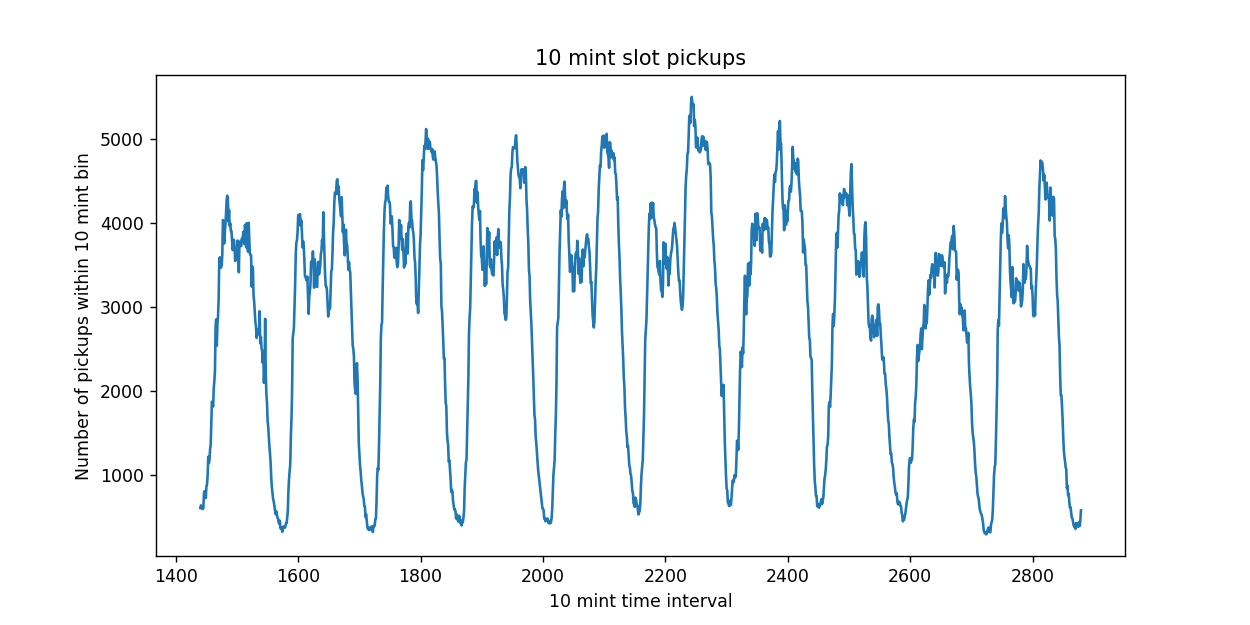

In [13]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_groupby_10m.index[10*6*24:10*6*24*2],jan_2015_groupby_10m[10*6*24:10*6*24*2])
plt.xlabel("10 mint time interval")
plt.ylabel("Number of pickups within 10 mint bin")
plt.title("10 mint slot pickups")
plt.show()

### Observation: -
we can see above plot: - 10 minutes interval vs Number of pickups, simply see re occurring patter is number of pickups repeating each day,
its starting low at mid night and then morning increasing and then slight again ups at evening.


<IPython.core.display.Javascript object>


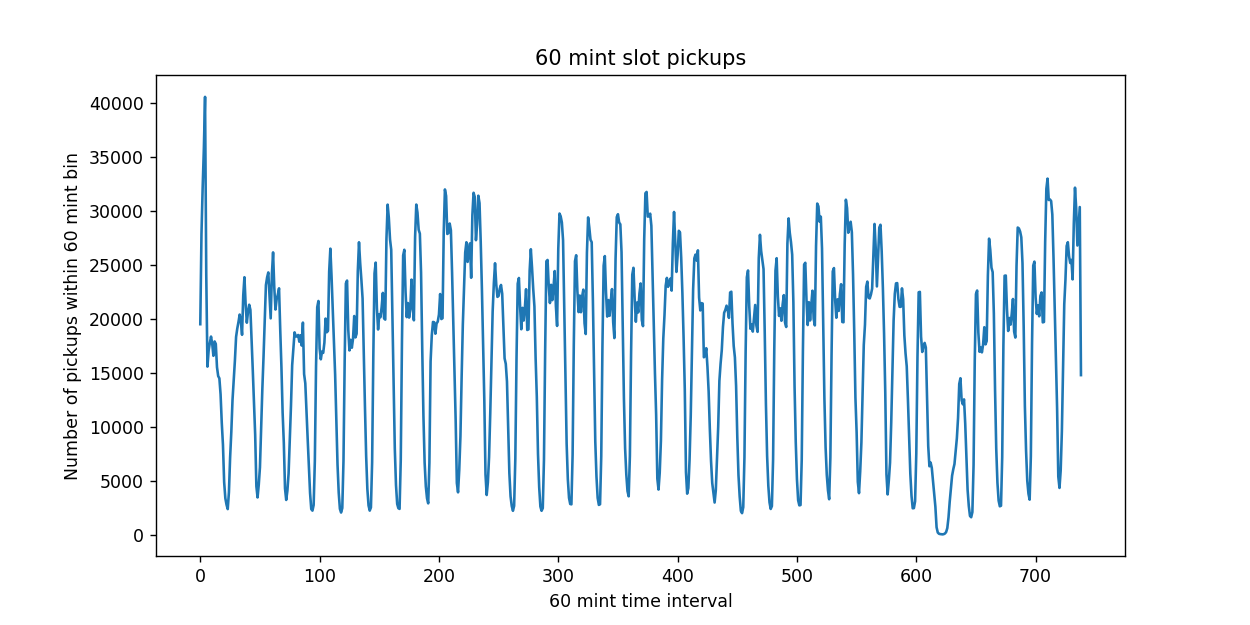

In [31]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_groupby_60m.index,jan_2015_groupby_60m)
plt.xlabel("60 mint time interval")
plt.ylabel("Number of pickups within 60 mint bin")
plt.title("60 mint slot pickups")
plt.show()

<IPython.core.display.Javascript object>


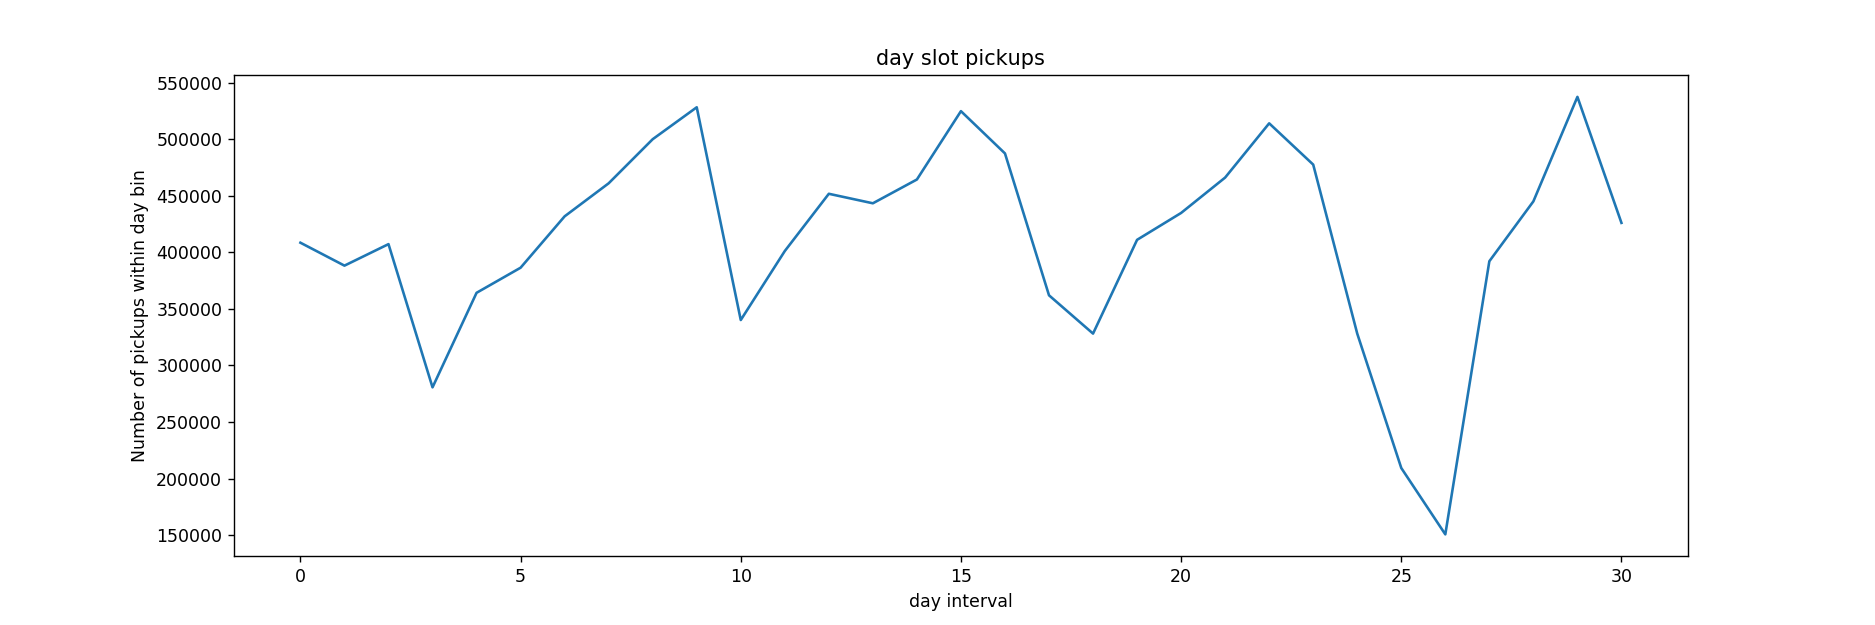

In [30]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_groupby_day.index[:],jan_2015_groupby_day[:])
plt.xlabel("day interval")
plt.ylabel("Number of pickups within day bin")
plt.title("day slot pickups")
plt.show()

### Observation:-
we can see above plot:- day interval vs Number of pickups, Its getting high in weekdays and low at weekends

### 2. Trip Duration
its time taken for one trip, (tpep_pickup_datetime - tpep_dropoff_datetime)

<IPython.core.display.Javascript object>


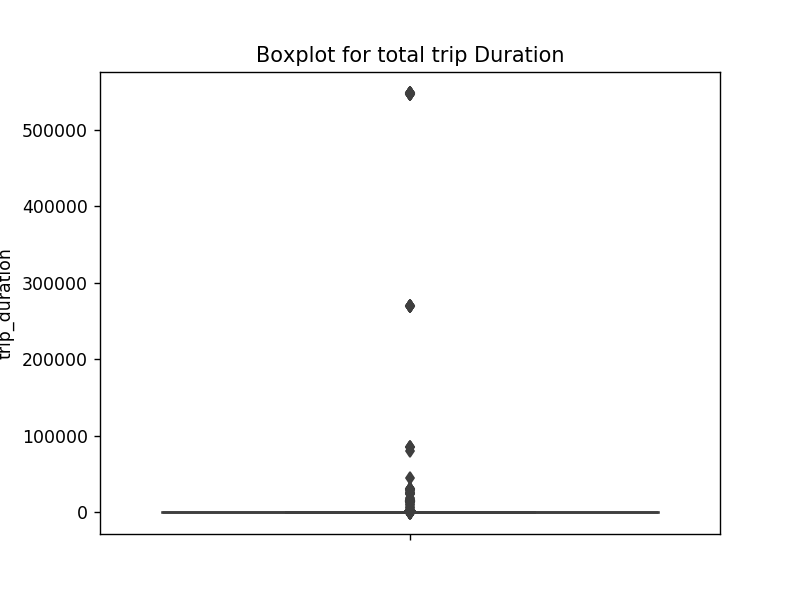

In [53]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_duration", data =jan_data)
plt.title("Boxplot for total trip Duration### 1. Pickup Latitude and Pickup Longitude
plt.show()

### Observation:-
According to NYC Taxi &amp; Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.
so we can see bunch of outliers here, will remove all row having duration > 12*60 mints in Data Cleaning part

### 3. Speed

C:\Users\MrRaj\Anaconda3\envs\demo\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


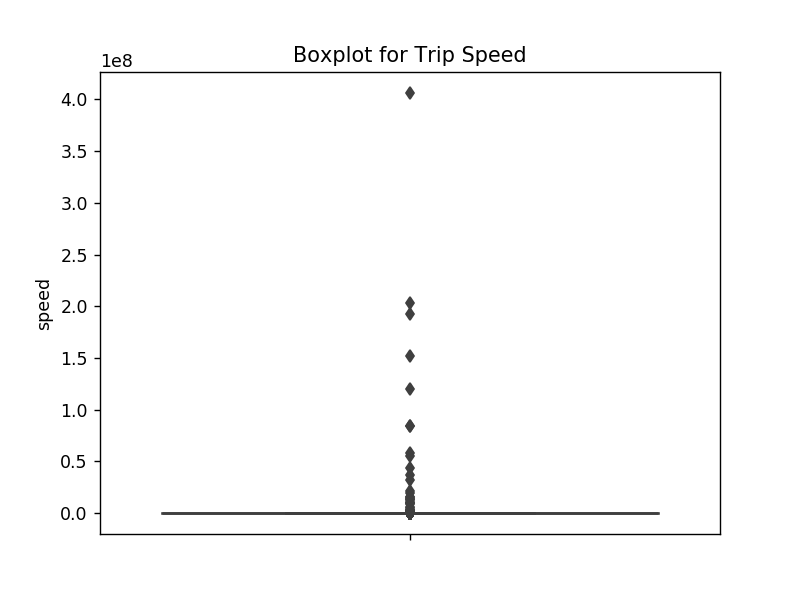

In [52]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="speed", data =jan_data)
plt.title("Boxplot for Trip Speed")
plt.show()

In [47]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0,1.0,0.1):
    var =jan_data["speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 36.80629539951574
99.1 percentile value is 37.47211895910781
99.2 percentile value is 38.2092555331992
99.3 percentile value is 39.03856903297931
99.4 percentile value is 40.0
99.5 percentile value is 41.142857142857146
99.6 percentile value is 42.61799217731421
99.7 percentile value is 44.854197349042714
99.8 percentile value is 52.77777777777777
99.9 percentile value is nan
100 percentile value is  nan


### Observation:-
can see 99.9 percentile of SPEED is NAN number so will take 52m/h speed as cut of speed and more than 52m/h speed rows will remove

### 4. Total fare
lets try if there are any outliers in based on the total_amount
#box-plot showing outliers in fare

<IPython.core.display.Javascript object>


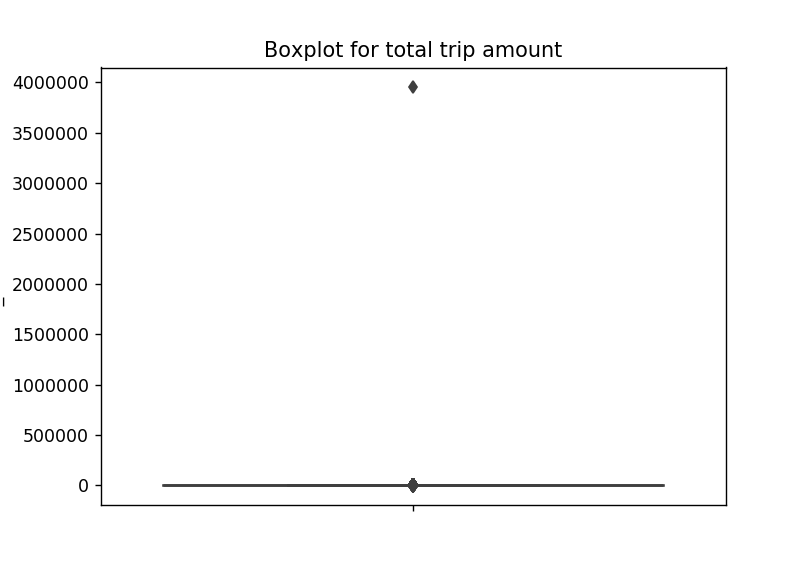

In [51]:
sns.boxplot(y="total_amount", data = jan_data)
plt.title("Boxplot for total trip amount")
plt.show()

### Observation:
We can see most of fare amount in boxplot is down few outliers are also there in top. will remove those in data cleaning 

### 5. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [56]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = jan_data[((jan_data.pickup_longitude <= -74.15) | (jan_data.pickup_latitude <= 40.5774)| \
                   (jan_data.pickup_longitude >= -73.7004) | (jan_data.pickup_latitude >= 40.9176))]
len(outlier_locations)

247742

### Observation:-
As you can see above that there are 247742 points outside the boundary of NY

### 6. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [58]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = jan_data[((jan_data.dropoff_longitude <= -74.15) | (jan_data.dropoff_latitude <= 40.5774)| \
                   (jan_data.dropoff_longitude >= -73.7004) | (jan_data.dropoff_latitude >= 40.9176))]

len(outlier_locations)

264440

### Observation:- 
As you can see above that there are 264440 points outside the boundary of NY

### 7. Trip Distance

<IPython.core.display.Javascript object>


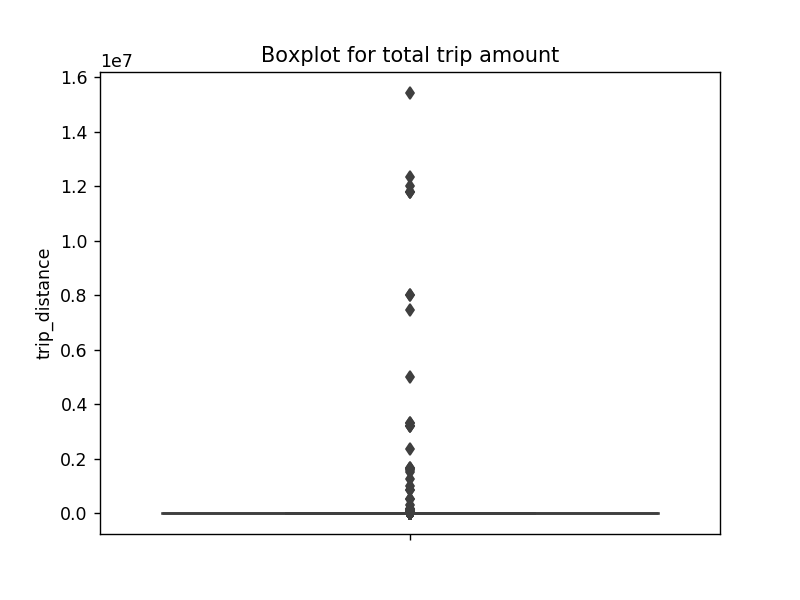

In [14]:
sns.boxplot(y="trip_distance", data = jan_data)
plt.title("Boxplot for total trip amount")
plt.show()

In [15]:
for i in np.arange(0.0,1.0,0.1):
    var =jan_data["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.22
99.1 percentile value is 18.43
99.2 percentile value is 18.68
99.3 percentile value is 18.92
99.4 percentile value is 19.23
99.5 percentile value is 19.6
99.6 percentile value is 20.1
99.7 percentile value is 20.68
99.8 percentile value is 21.4
99.9 percentile value is 23.1
100 percentile value is  15420004.5


### Observation:-
<p>We can see Boxplot of Trip_distance is showing outliers at top.</p>
can see 99.9 percentile of trip_distance is 23.1 mile so will take is as cut of speed.